In [22]:
# need error channels for qutrits
# reference:
# [1] M. Grassl, L. Kong, Z. Wei, Z.-Q. Yin, and B. Zeng, “Quantum Error-Correcting Codes for Qudit Amplitude Damping,” IEEE Trans. Inform. Theory, vol. 64, no. 6, pp. 4674–4685, Jun. 2018, doi: 10.1109/TIT.2018.2790423.

import numpy as np
from qutip import Qobj, basis
from quantum_logical.error_channel import (
    AmplitudeDamping,
    PhaseDamping,
    QutritAmplitudeDamping,
)
import numpy as np
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip.operators import sigmax, sigmay, sigmaz
from qutip import basis
from qutip import expect
from quantum_logical.error_channel import ErrorChannel
from qutip import qeye, tensor
from qutip import Qobj, basis, tensor, expect
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.error_channel import QutritAmplitudeDamping

In [23]:
# Define the number of qubits
N = 1  # Number of qubits
delays = np.linspace(0, 25, 25)  # Sweeping delay from 0 to 10

# Initialize T1 and T2 times for each qubit
T1s = [1] * N
T2s = [1] * N  # Assuming all qubits have the same T2 time
trotter_step_size = 0.2
k1, k2 = 1, 1

# Create initial states for a N-qubit system
d = 3
f_rho = basis(d, 2) * basis(d, 2).dag()  # |f><f|

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([f_rho] * N)
initial_state /= initial_state.norm()

In [24]:
# Define basis states for qutrits
g = basis(3, 0)  # |g> state
e = basis(3, 1)  # |e> state
f = basis(3, 2)  # |f> state


# Define observables for qutrits
observables = {
    "g": tensor([g] * N) * tensor([g] * N).dag(),
    "e": tensor([e] * N) * tensor([e] * N).dag(),
    "f": tensor([f] * N) * tensor([f] * N).dag(),
}

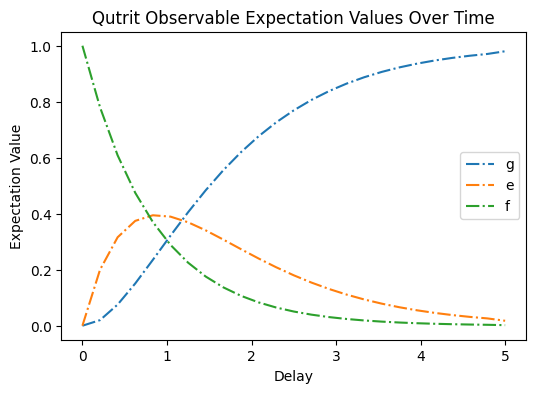

In [25]:
# Modify the experiment function for qutrits
def multi_qutrit_experiment(rho_initial, delay, trotter_step_size):
    # Initialize the qutrit amplitude damping channel with the provided gamma parameters
    error_channel = QutritAmplitudeDamping(0.1, k1, k2, trotter_step_size)
    rho_final = error_channel.apply_error_channel(rho_initial, delay)
    # Fidelity calculation for qutrits may need adjustment
    fid = fidelity(rho_initial, rho_final)
    return rho_final, fid


# Modify the plot function for qutrits
def plot_observable_decay_qutrits(state, observables, delays, trotter_step_size):
    plt.figure(figsize=(6, 4))
    for label, obs in observables.items():
        exp_values = []
        for delay in delays:
            rho_final, _ = multi_qutrit_experiment(state, delay, trotter_step_size)
            exp_value = expect(obs, rho_final)
            exp_values.append(exp_value)
        plt.plot(delays, exp_values, "-.", label=label)
    plt.legend()
    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Qutrit Observable Expectation Values Over Time")
    plt.show()


# Define the delays and gamma parameters
delays = np.linspace(0, 5, 25)
trotter_step_size
# Run the experiment
plot_observable_decay_qutrits(initial_state, observables, delays, trotter_step_size)